# Reference mapping with PEIVI

After obtaining the reference and query gene score sets as well as the peak embeddings for each batch, we use the main ``PEIVI`` model to construct the reference model and save it. In this tutorial, we employ a five-batch PBMC dataset, with three batches designated as the reference and two batches as the query.

In [1]:
## load epipack package

# !pip install --upgrade epipackpy
import scanpy as sc
import numpy as np
import pandas as pd

import epipackpy as epk
print(epk.__version__)

1.0.1dev4


In [3]:
peak_1 = sc.read_h5ad("data/pbmc_batch/pbmc_5k_nextgem/peak_1.h5ad")
peak_2 = sc.read_h5ad("data/pbmc_batch/pbmc_10k_nextgem/peak_2.h5ad")
peak_3 = sc.read_h5ad("data/pbmc_batch/pbmc_10k_chromiumX/peak_3.h5ad")
peak_4 = sc.read_h5ad("data/pbmc_batch/pbmc_10k_Chromium_Controller/peak_4.h5ad")
peak_5 = sc.read_h5ad("data/pbmc_batch/pbmc_multiome/peak_6.h5ad")

genescore_mtx = sc.read_h5ad("data/pbmc_batch/pbmc_5b_genemtx.h5ad")

ref1 = genescore_mtx[genescore_mtx.obs['batch_id']=='batch 1']
ref2 = genescore_mtx[genescore_mtx.obs['batch_id']=='batch 2']
ref3 = genescore_mtx[genescore_mtx.obs['batch_id']=='batch 6']
ref = sc.concat([ref1, ref2, ref3])

query_1 = genescore_mtx[genescore_mtx.obs['batch_id']=='batch 3']
query_2 = genescore_mtx[genescore_mtx.obs['batch_id']=='batch 4']
query = sc.concat([query_1, query_2])

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Model training

Before training the model, we first need to normalize the raw expression matrix.

In [4]:
sc.pp.normalize_total(ref, target_sum=1e4)
sc.pp.log1p(ref)

sc.pp.normalize_total(query, target_sum=1e4)
sc.pp.log1p(query)

The ``PEIVI`` model uses the normalized expression matrix as input, along with the concatenated peak embeddings and batch encodings. This procedure is consistent across both reference construction and query mapping. We begin by constructing the reference model.

In [8]:
#batch encoding

ref.obs['batch_code'] = pd.Categorical(ref.obs['batch_id']).codes.astype(int)

#peak concat
adatas = [peak_1, peak_2, peak_5]
peak_emb = np.concatenate([a.obsm['epipack_z_bce'] for a in adatas], axis=0)

In [9]:
epk_base = epk.ml.PEIVI(count=ref.X, peak_emb = peak_emb,
                         batch_id=ref.obs['batch_code'], reg_mmd=10, reg_rec=1, reg_z_l2=1, use_batch_norm=False, use_layer_norm=True)

#train model
epk_base.train_model(pre_train_epoch=50, nepochs=100)

#get latent reference embedding
ref.obsm['z_ref'] = epk_base.get_latent()

- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 100/100 [01:57<00:00,  1.17s/it, val_kl_loss=1.96e+5, val_loss_z_dist=25.5, val_mmd=0.176, val_rec_loss=1.93e+3]


[Optional] You may use the [pickle](https://docs.python.org/3/library/pickle.html) module to save the pre-trained reference model for query mapping. The model saving and loading code are provided as follows.

In [11]:
#save model
import pickle

with open("epk_model.pkl", "wb") as f:
    pickle.dump(epk_base, f)

In [13]:
#load model
with open("epk_model.pkl", "rb") as f:
    epi_integration_loaded = pickle.load(f)

### Query mapping

We will use the pretrained reference model to perform query mapping. The first step is to create the query model.

In [15]:
query.obs['batch_code'] = pd.Categorical(query.obs['batch_id']).codes.astype(int)

adatas = [peak_3, peak_4]
peak_emb = np.concatenate([a.obsm['epipack_z_bce'] for a in adatas], axis=0)

In addition to the objects required by the reference model, the mapping model also requires the reference mapping ``ref.obsm['z_ref']`` to serve as the distributional baseline.

In [16]:
epk_query = epk.ml.PEIVI_MAPPING(promoter_dt=query.X, enhancer_z = peak_emb, ref_embedding=ref.obsm['z_ref'],
                         batch_id=query.obs['batch_code'], reg_mmd=10, reg_mmd_inter = 100, reg_rec=0.1, reg_z_l2=0.1, use_batch_norm=False,use_layer_norm=True)

- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Then use ``query_model_initial`` function to initialize query model parameters.

In [17]:
query_model = epk.ml.query_model_initial(epk_query, epi_integration_loaded.state_dict(), query_batch_num=2)

In [18]:
#train query model
query_model.train_model(nepochs=100)
query.obsm['z_query'] = query_model.get_latent()

Epochs: 100%|██████████| 100/100 [02:58<00:00,  1.78s/it, val_kl_loss=1.97e+5, val_loss_z_dist=36.5, val_mmd=0.0382, val_mmd_inter=0.0511, val_rec_loss=1.81e+3]


The mapped embedding ``query.obsm['z_query']`` and annotated reference embedding ``ref.obsm['z_ref']`` will be further used to transfer cell labels and discover OOR cell states in query.

### [Optional] Data visualization

To visualize the PEIVI’s learned embeddings, we use UMAP. Since this data has been used for benchmarking, we can use the curated label to see if the reference mapping worked reasonably well.

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: The 'old_style' error capturing is deprecated and will be replaced by `new_style` in a future release.
  init_rp_tree(data, dist, current_graph, leaf_array)
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: The 'old_style' error capturing is deprecated and will be

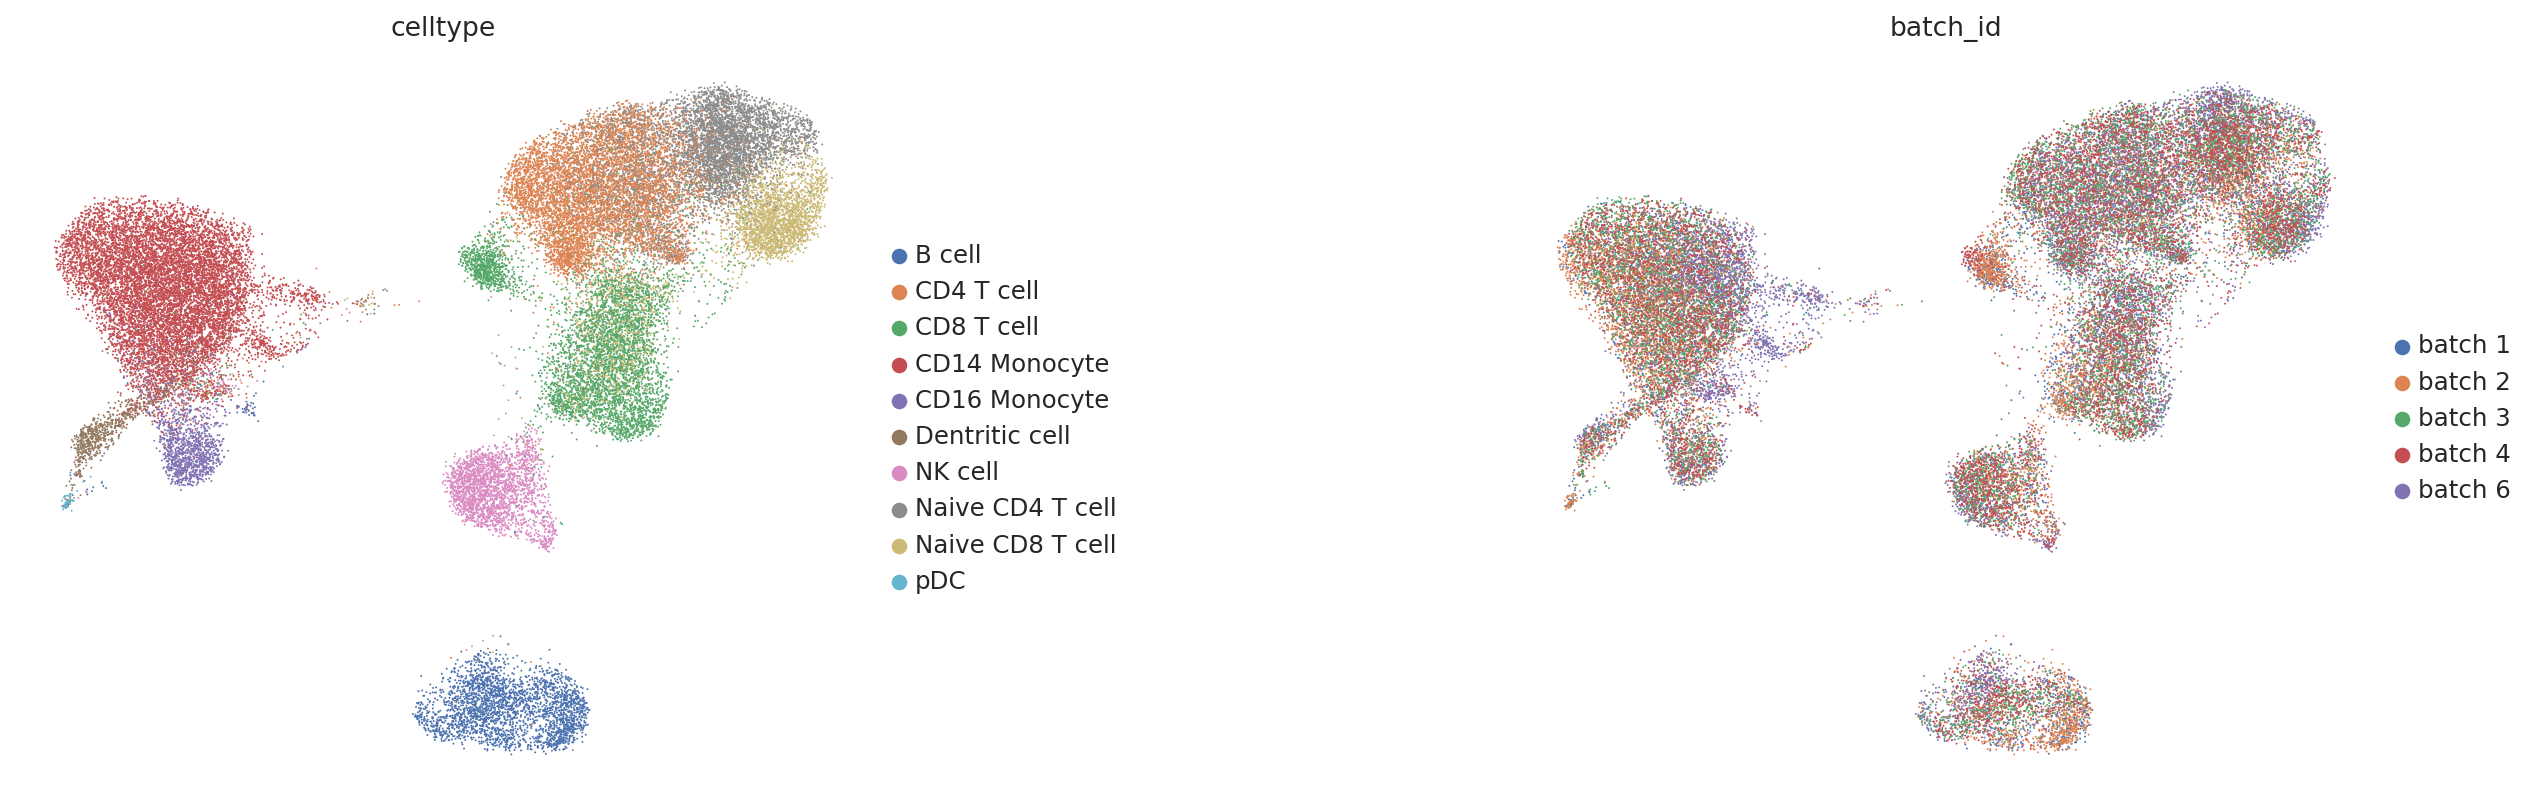

In [19]:
import seaborn as sns

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()

tmp = sc.concat([ref, query])
tmp.obsm['z_tmp'] = np.concatenate([ref.obsm['z_ref'], query.obsm['z_query']])

sc.pp.neighbors(tmp, n_neighbors=50, use_rep='z_tmp')
sc.tl.umap(tmp)
#sc.tl.leiden(tmp, resolution=1.5)
sc.pl.umap(tmp, color=['celltype', 'batch_id'], ncols=2, wspace=0.6)

We can observe that the query data (batches 3 and 4 in the right panel) are well integrated into the reference space, while the cell type clusters remain clearly separated.